## Example Notebook of using different samplers for Bayesian Inference in MAPS using linear spherical harmonics
First let's import the necessary packages

In [1]:
# If you are just testing this package without installing, you can add the package to the path
import sys
sys.path.insert(0,'../..')
import maps
print('Using maps from', maps.__file__)

Using maps from /Users/kushagran.nag/IPTA_GWB/anisotropy/MAPS/MAPS/docs/Bayesian_inference/../../maps/__init__.py


In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from maps import anis_pta as ap
from maps import utils

import numpy.random as rn
from enterprise.signals import anis_coefficients as ac
import bilby
import pandas as pd
import pickle, corner
from la_forge import core, diagnostics

Optional mpi4py package is not installed.  MPI support is not available.


/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Simulate data

In MAPS, we consider amplitude scaled pulsar pairs cross-correlations ($\rho$) as our data. This can be modelled by the detector Overlap Reduction Function (ORF) given as $\Gamma = A (R \cdot P)$. Where, $A$ is the amplitude correction parameter. In spherical harmonic expansion the GWB power $P$ is represented as: $P = \sum_{l=0}^{\infty} \sum_{m=-l}^{+l} c_{lm} Y_{lm}(\theta, \phi)$.

In this example, to simulate $\Gamma$, first we define 67 pulsars uniformly distributed accross the sky, $nside$ defining the no. of pixel tessellation of the healpix sky (and hence no. of pixels in the sky), $l_{max}$ defining the maximum angular resolution of the sky to use for spherical harmonics representation.

In [3]:
### Create a random draw generator with a seed
rng = rn.default_rng(seed=316)

In [4]:
npsrs = 67
nside = 8
### We are using l_max=4 for illustration purposes. 
### However, with 67 pulsars we can go upto root(67) ~ l_max=8
l_max = 4
nclm = int((l_max+1)**2)

ncc = int(npsrs*(npsrs-1)/2)

print(f"Using {npsrs} pulsars with {ncc} pairs.")

Using 67 pulsars with 2211 pairs.


In [5]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = npsrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = npsrs))

Now, initiate a PTA object without correlation values to gain access to some useful functions. Note that we can set data afterwards. Here, we define the basis in which we search for anisotropy. In this example, we use 'power_basis' which is the linear spherical harmonics basis.

In [6]:
pta = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max, mode = 'power_basis')

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


Some of the important functions that this sets up are: the response matrix $R$ of shape ($N_{cross-correlations} \times N_{pix}$), real-valued spherical harmonics $Y_{lm}(\theta, \phi)$ of shape ($N_{clm} \times N_{pix}$) and hence $\Gamma_{lm} = Y_{lm} \cdot R^{T}$ of shape ($N_{clm} \times N_{cross-correlations}$).

### Inject anisotropy

In this example, we can create injections using $2$ methods.

1. Adding a hotspot to an isotropic background: 
       We generate this as individual pixel powers. For an isotropic background, we can supply a pixel vector of all 1, meaning even power throughout the sky. On top of this, select a circular area on the sky at ($\theta$, $\phi$) for which we increase the power. We then combine this simulated map of shape ($N_{pix}$) with $R$ to create the injected data. 

2. With $c_{lm}$ values: 
       We generate random $c_{lm}$ values with $c_{00}=\sqrt{4 \pi}$ and combine it with $\Gamma_{lm}$ to create the injected data.

Note that while MAPS does support pair covariance, this example will not use it.

Here, we use method $1$ and use a handy function in utils: ``` utils.inject_anisotropy(pta, method, **arg) ```. Here, all **arg are optional. This function creates the <span style="color:blue">injection</span> attributes of anis_pta instance/object. <span style="color:blue">pta.injected_rho</span>, <span style="color:blue">pta.injected_sig</span>, and <span style="color:blue">pta.injected_pair_cov</span> contains the injected cross_correlations ($\rho$) data, $1-d$ uncertainties on $\rho$, and diagonal pair-covariance matrix (None if not supplied) respectively. 

* With method 1, <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> contains an array of injected pixel power, and angular power spectrum respectively which is very handy for post processing.

* With method 2, <span style="color:blue">pta.injected_clms</span>, <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> contains an array of injected $c_{lm}$'s, pixel power, and angular power spectrum respectively which is very handy for post processing.

In [7]:
### One can add random noise using add_rand_noise=True 
### which adds gaussian noise scaled by sim_sig

### For method 1:
utils.inject_anisotropy(pta, method='pixel', sim_log10_A2=0.0, sim_power=50, sim_theta=np.pi/3, sim_phi=np.pi/2, lonlat=False, 
                        sim_pixel_radius=10, sim_sig=0.1, pair_cov=False, return_vals=False, add_rand_noise=False)

### For method 2:
### Note that we can supply a list of clm value to inject using sim_clms.
### If it's None then the values are randomly generated internally with seed=seed (optional).
#utils.inject_anisotropy(pta, method='power_basis', sim_clms=None, seed=316)

Let's look at the injection in the skymap and ORF representation.

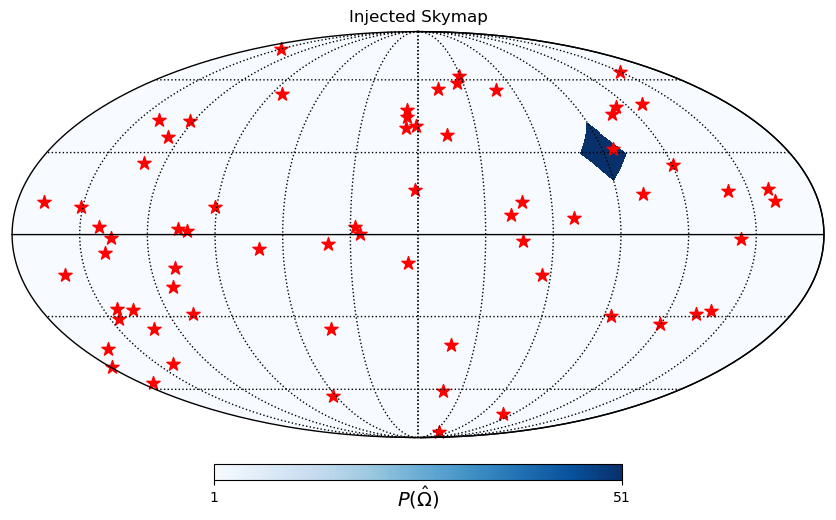

In [8]:
# Plot the injection
hp.mollview(pta.injected_power,title = 'Injected Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(pta.psrs_theta, pta.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()

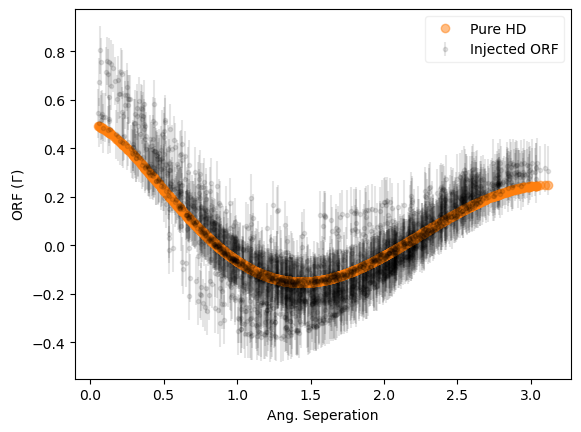

In [9]:
plt.errorbar(pta.xi, pta.injected_rho, pta.injected_sig, marker='.', color='black', alpha=0.1, ls='', label='Injected ORF')
plt.plot(pta.xi, pta.get_pure_HD(), color='tab:orange', alpha=0.5, marker='o', ls='', label='Pure HD')

plt.xlabel('Ang. Seperation')
plt.ylabel(r'ORF ($\Gamma$)')

plt.legend(framealpha=0.3)
plt.show()

## Now let's run our bayesian inference

First we supply our anis_pta object, the cross-correlation and uncertainty data we generated.

In [10]:
### Note that here pta.injected_pair_cov is None as we didn't supply it while creating the data
pta.set_data(rho=pta.injected_rho, sig=pta.injected_sig, os=1, covariance=pta.injected_pair_cov)

### Using PTMCMC, dynesty, dynamic dynesty and emcee sampler

We will be working with difference samplers. Other than PTMCMC, all other samplers are defined in **bilby**. **dynamic_dynesty** allows for a posterior oriented run with **dynesty** sampler. Note that the ```set_ptmcmc(**args)``` function lives inside the **anis_pta** object. Whereas, ```set_bilby(pta, **args)``` lives inside the ```anis_pta.py``` framework where we need to pass in the **anis_pta** object.

* In all cases, the priors here are set internally. Specifically, for PTMCMC, The type of priors can be specified by the 'prior_form' argument. Currently, it accepts 'Uniform', 'Normal' or 'TruncNormal'.

* In all cases, one can pass the min, max prior boundaries and can access these priors with <span style="color:blue">priors</span> attribute of anis_pta object. Also, note that we can pickle the **anis_pta** object using the ```(save_anis_pta=True)``` flag to the outdir for better post-processing.

First, we run the inference with PTMCMC sampler and then for all the bibly samplers used here.

#### 1. PTMCMC Inference

In [11]:
### set an output directory for ptmcmc
ptmcmc_outdir = './bayes_data/linear_basis/ptmcmc/'

In [12]:
### Setup the ptmcmc sampler.
ptmcmc_sampler = pta.set_ptmcmc(prior_form='Uniform', log10_A2_prior_min=-2, log10_A2_prior_max=2,
                                clm_prior_min=-5, clm_prior_max=5, 
                                outdir=ptmcmc_outdir, resume=True, save_anis_pta=True)

In [13]:
# sampler for N steps
N = int(1e6)
x0 = np.array([p.sample() for p in pta.priors])

In [14]:
### let's sample
ptmcmc_sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent (0.00 percent of new work) in 0.001706 s Acceptance rate = 0

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent (1.00 percent of new work) in 3.038927 s Acceptance rate = 0.359211Adding DE jump with weight 50
Finished 100.00 percent (100.00 percent of new work) in 326.731192 s Acceptance rate = 0.374408
Run Complete


#### 2. Bilby Inference

Look at bilby documentation for looking at the samplers compatible with [Bilby](https://bilby-dev.github.io/bilby/api/bilby.core.sampler.html). Note that with defining a custom bilby likelihood (like we have done for MAPS), bilby internally converts the structure of likelihood according to the sampler we use to perform inference. However, pymc sampler requires a symbolic definition of the likelihood and will throw errors if we use it. Make sure that you install bilby and the samplers in it which you wish to use.

* Again first we set an output directory for bilby (different for different samplers). 

* Then instantiate the bilby likelihood class ```set_bilby(pta, **args)``` which lives in anis_pta.py framework not in anis_pta class. Here, we name the instance as bilby_bayes. We do this here for each sampler seperately. 

* Note we need to pass it the anis_pta object. And here again the uniform pirors for our parameters are set internally according to bilby compatibility where one can pass the min and max prior boundaries. One can access these priors with <span style="color:blue">priors</span> attribute of anis_pta.set_bilby instance. Also, note that we can pickle the anis_pta object to the outdir for better post-processing.

* Finally, we use the ```bilby.core.sampler.run_sampler``` primary interface for parameter estimation. Here, we need to pass in the bilby likelihood instance (here we name it bilby_bayes), the priors (an attribute of bilby_bayes), sampler's name, parameters for the sampler (like nsteps & nwalkers for emcee), outdir and a label. Note that different samplers might require different/more parameters.

In [17]:
### samplers we work with here
bb_samplers_names = ['dynesty', 'dynamic_dynesty', 'emcee']

In [18]:
### set an output directory for bilby seperate for each sampler
bb_outdir = './bayes_data/linear_basis/'
bb_samplers_outdir = [bb_outdir+s+'/' for s in bb_samplers_names]

In [19]:
### seting up bilby samplers with their parameters
bb_samplers = dict(
    dynesty = dict(nlive=500, dlogz=0.1, sample="rwalk"),
    dynamic_dynesty = dict(sample="rwalk", nlive_init=500, nlive_batch=500, wt_kwargs={'pfrac': 1.0}), #n_effective can be used to obtain how many samples
    emcee = dict(nsteps= 5000, nwalkers=200),
)

In [23]:
### Instantiate the custom bilby likelihood
bilby_bayes = [ap.set_bilby(pta, log10_A2_prior_min=-2, log10_A2_prior_max=2, 
                           clm_prior_min=-5, clm_prior_max=5, 
                           outdir=s_out, save_anis_pta=True) for s_out in bb_samplers_outdir]

In [24]:
### Launch each sampler
results = dict()

for i,samps in enumerate(bb_samplers):
    result = bilby.core.sampler.run_sampler(
        bilby_bayes[i],
        priors = bilby_bayes[i].priors,
        sampler = samps,
        label = samps,
        resume = False,
        clean = True,
        **bb_samplers[samps],
        outdir = bb_samplers_outdir[i]
    )
    results[samps] = result

01:03 bilby INFO    : Running for label 'dynesty', output will be saved to './bayes_data/linear_basis/dynesty/'
01:03 bilby INFO    : Analysis priors:
01:03 bilby INFO    : log10_A2=Uniform(minimum=-2, maximum=2, name='log10_A2', latex_label='log10_A2', unit=None, boundary=None)
01:03 bilby INFO    : c_1-1=Uniform(minimum=-5, maximum=5, name='c_1-1', latex_label='c_1-1', unit=None, boundary=None)
01:03 bilby INFO    : c_10=Uniform(minimum=-5, maximum=5, name='c_10', latex_label='c_10', unit=None, boundary=None)
01:03 bilby INFO    : c_11=Uniform(minimum=-5, maximum=5, name='c_11', latex_label='c_11', unit=None, boundary=None)
01:03 bilby INFO    : c_2-2=Uniform(minimum=-5, maximum=5, name='c_2-2', latex_label='c_2-2', unit=None, boundary=None)
01:03 bilby INFO    : c_2-1=Uniform(minimum=-5, maximum=5, name='c_2-1', latex_label='c_2-1', unit=None, boundary=None)
01:03 bilby INFO    : c_20=Uniform(minimum=-5, maximum=5, name='c_20', latex_label='c_20', unit=None, boundary=None)
01:03 bil

41901it [04:40, 138.18it/s, bound:1713 nc: 32 ncall:1.1e+06 eff:3.9% logz=2863.03+/-0.38 dlogz:0.1>0.1]     

01:08 bilby INFO    : Written checkpoint file ./bayes_data/linear_basis/dynesty//dynesty_resume.pickle


41901it [05:00, 138.18it/s, bound:1713 nc:  1 ncall:1.1e+06 eff:4.0% logz=2863.05+/-0.39 dlogz:0.000205>0.1]

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:08 bilby WARNING : Axis limits cannot be NaN or Inf
01:08 bilby WARNING : Failed to create dynesty run plot at checkpoint


41901it [05:27, 127.92it/s, bound:1713 nc:  1 ncall:1.1e+06 eff:4.0% logz=2863.05+/-0.39 dlogz:0.000205>0.1]

01:08 bilby INFO    : Rejection sampling nested samples to obtain 4100 posterior samples
01:08 bilby INFO    : Sampling time: 0:05:27.544107


01:08 bilby INFO    : Summary of results:
nsamples: 4100
ln_noise_evidence:    nan
ln_evidence: 2863.054 +/-  0.441
ln_bayes_factor:    nan +/-  0.441

01:08 bilby INFO    : Running for label 'dynamic_dynesty', output will be saved to './bayes_data/linear_basis/dynamic_dynesty/'
01:08 bilby INFO    : Analysis priors:
01:08 bilby INFO    : log10_A2=Uniform(minimum=-2, maximum=2, name='log10_A2', latex_label='log10_A2', unit=None, boundary=None)
01:08 bilby INFO    : c_1-1=Uniform(minimum=-5, maximum=5, name='c_1-1', latex_label='c_1-1', unit=None, boundary=None)
01:08 bilby INFO    : c_10=Uniform(minimum=-5, maximum=5, name='c_10', latex_label='c_10', unit=None, boundary=None)
01:08 bilby INFO    : c_11=Uniform(minimum=-5, maximum=5, name='c_11', latex_label='c_11', unit=None, boundary=None)
01:08 bilby INFO    : c_2-2=Uniform(minimum=-5, maximum=5, name='c_2-2', latex_label='c_2-2', unit=None, boundary=None)
01:08 bilby INFO    : c_2-1=Uniform(minimum=-5, maximum=5, name='c_2-1', latex

52254it [06:04, 510.39it/s, bound:119 nc:  1 ncall:1.4e+06 eff:3.8% logz=2862.94+/-0.38 batch:19 logl:2934.2 < 2944.3 < 2938.8 stop: 0.851]

01:15 bilby INFO    : Written checkpoint file ./bayes_data/linear_basis/dynamic_dynesty//dynamic_dynesty_resume.pickle
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:15 bilby WARNING : Axis limits cannot be NaN or Inf
01:15 bilby WARNING : Failed to create dynesty run plot at checkpoint


52254it [07:18, 119.20it/s, bound:119 nc:  1 ncall:1.4e+06 eff:3.8% logz=2862.94+/-0.38 batch:19 logl:2934.2 < 2944.3 < 2938.8 stop: 0.851]

01:16 bilby INFO    : Rejection sampling nested samples to obtain 6248 posterior samples
01:16 bilby INFO    : Sampling time: 0:07:18.375758


01:16 bilby INFO    : Summary of results:
nsamples: 6248
ln_noise_evidence:    nan
ln_evidence: 2862.951 +/-  0.332
ln_bayes_factor:    nan +/-  0.332

01:16 bilby INFO    : Running for label 'emcee', output will be saved to './bayes_data/linear_basis/emcee/'
01:16 bilby INFO    : Analysis priors:
01:16 bilby INFO    : log10_A2=Uniform(minimum=-2, maximum=2, name='log10_A2', latex_label='log10_A2', unit=None, boundary=None)
01:16 bilby INFO    : c_1-1=Uniform(minimum=-5, maximum=5, name='c_1-1', latex_label='c_1-1', unit=None, boundary=None)
01:16 bilby INFO    : c_10=Uniform(minimum=-5, maximum=5, name='c_10', latex_label='c_10', unit=None, boundary=None)
01:16 bilby INFO    : c_11=Uniform(minimum=-5, maximum=5, name='c_11', latex_label='c_11', unit=None, boundary=None)
01:16 bilby INFO    : c_2-2=Uniform(minimum=-5, maximum=5, name='c_2-2', latex_label='c_2-2', unit=None, boundary=None)
01:16 bilby INFO    : c_2-1=Uniform(minimum=-5, maximum=5, name='c_2-1', latex_label='c_2-1', unit

## Post-processing

#### 1. First load the data

Here, for bilby one can also use result.json file which is created by bilby to save the output which is separate to the ones that sampler save.

In [25]:
### For ptmcmc run
ptmcmc_core = core.Core(chaindir=ptmcmc_outdir, burn=0.25)

### For bilby runs if one wants to explicitly load the data
### bb_data = bilby.result.read_in_result('./bayes_data/linear_basis/dynesty/dynesty_result.json')
### emcee takes a lot of space

### If one wants to load the pickled anis_pta object
### with open(ptmcmc_outdir+'anis_pta.pickle', 'rb') as f:
###    pta = pickle.load(f)

#### 3. Now let's look at the corner plots

In [29]:
### Get array of samples to display a corner plot
ptmcmc_corner_params = ptmcmc_core.get_param(pta.param_names)

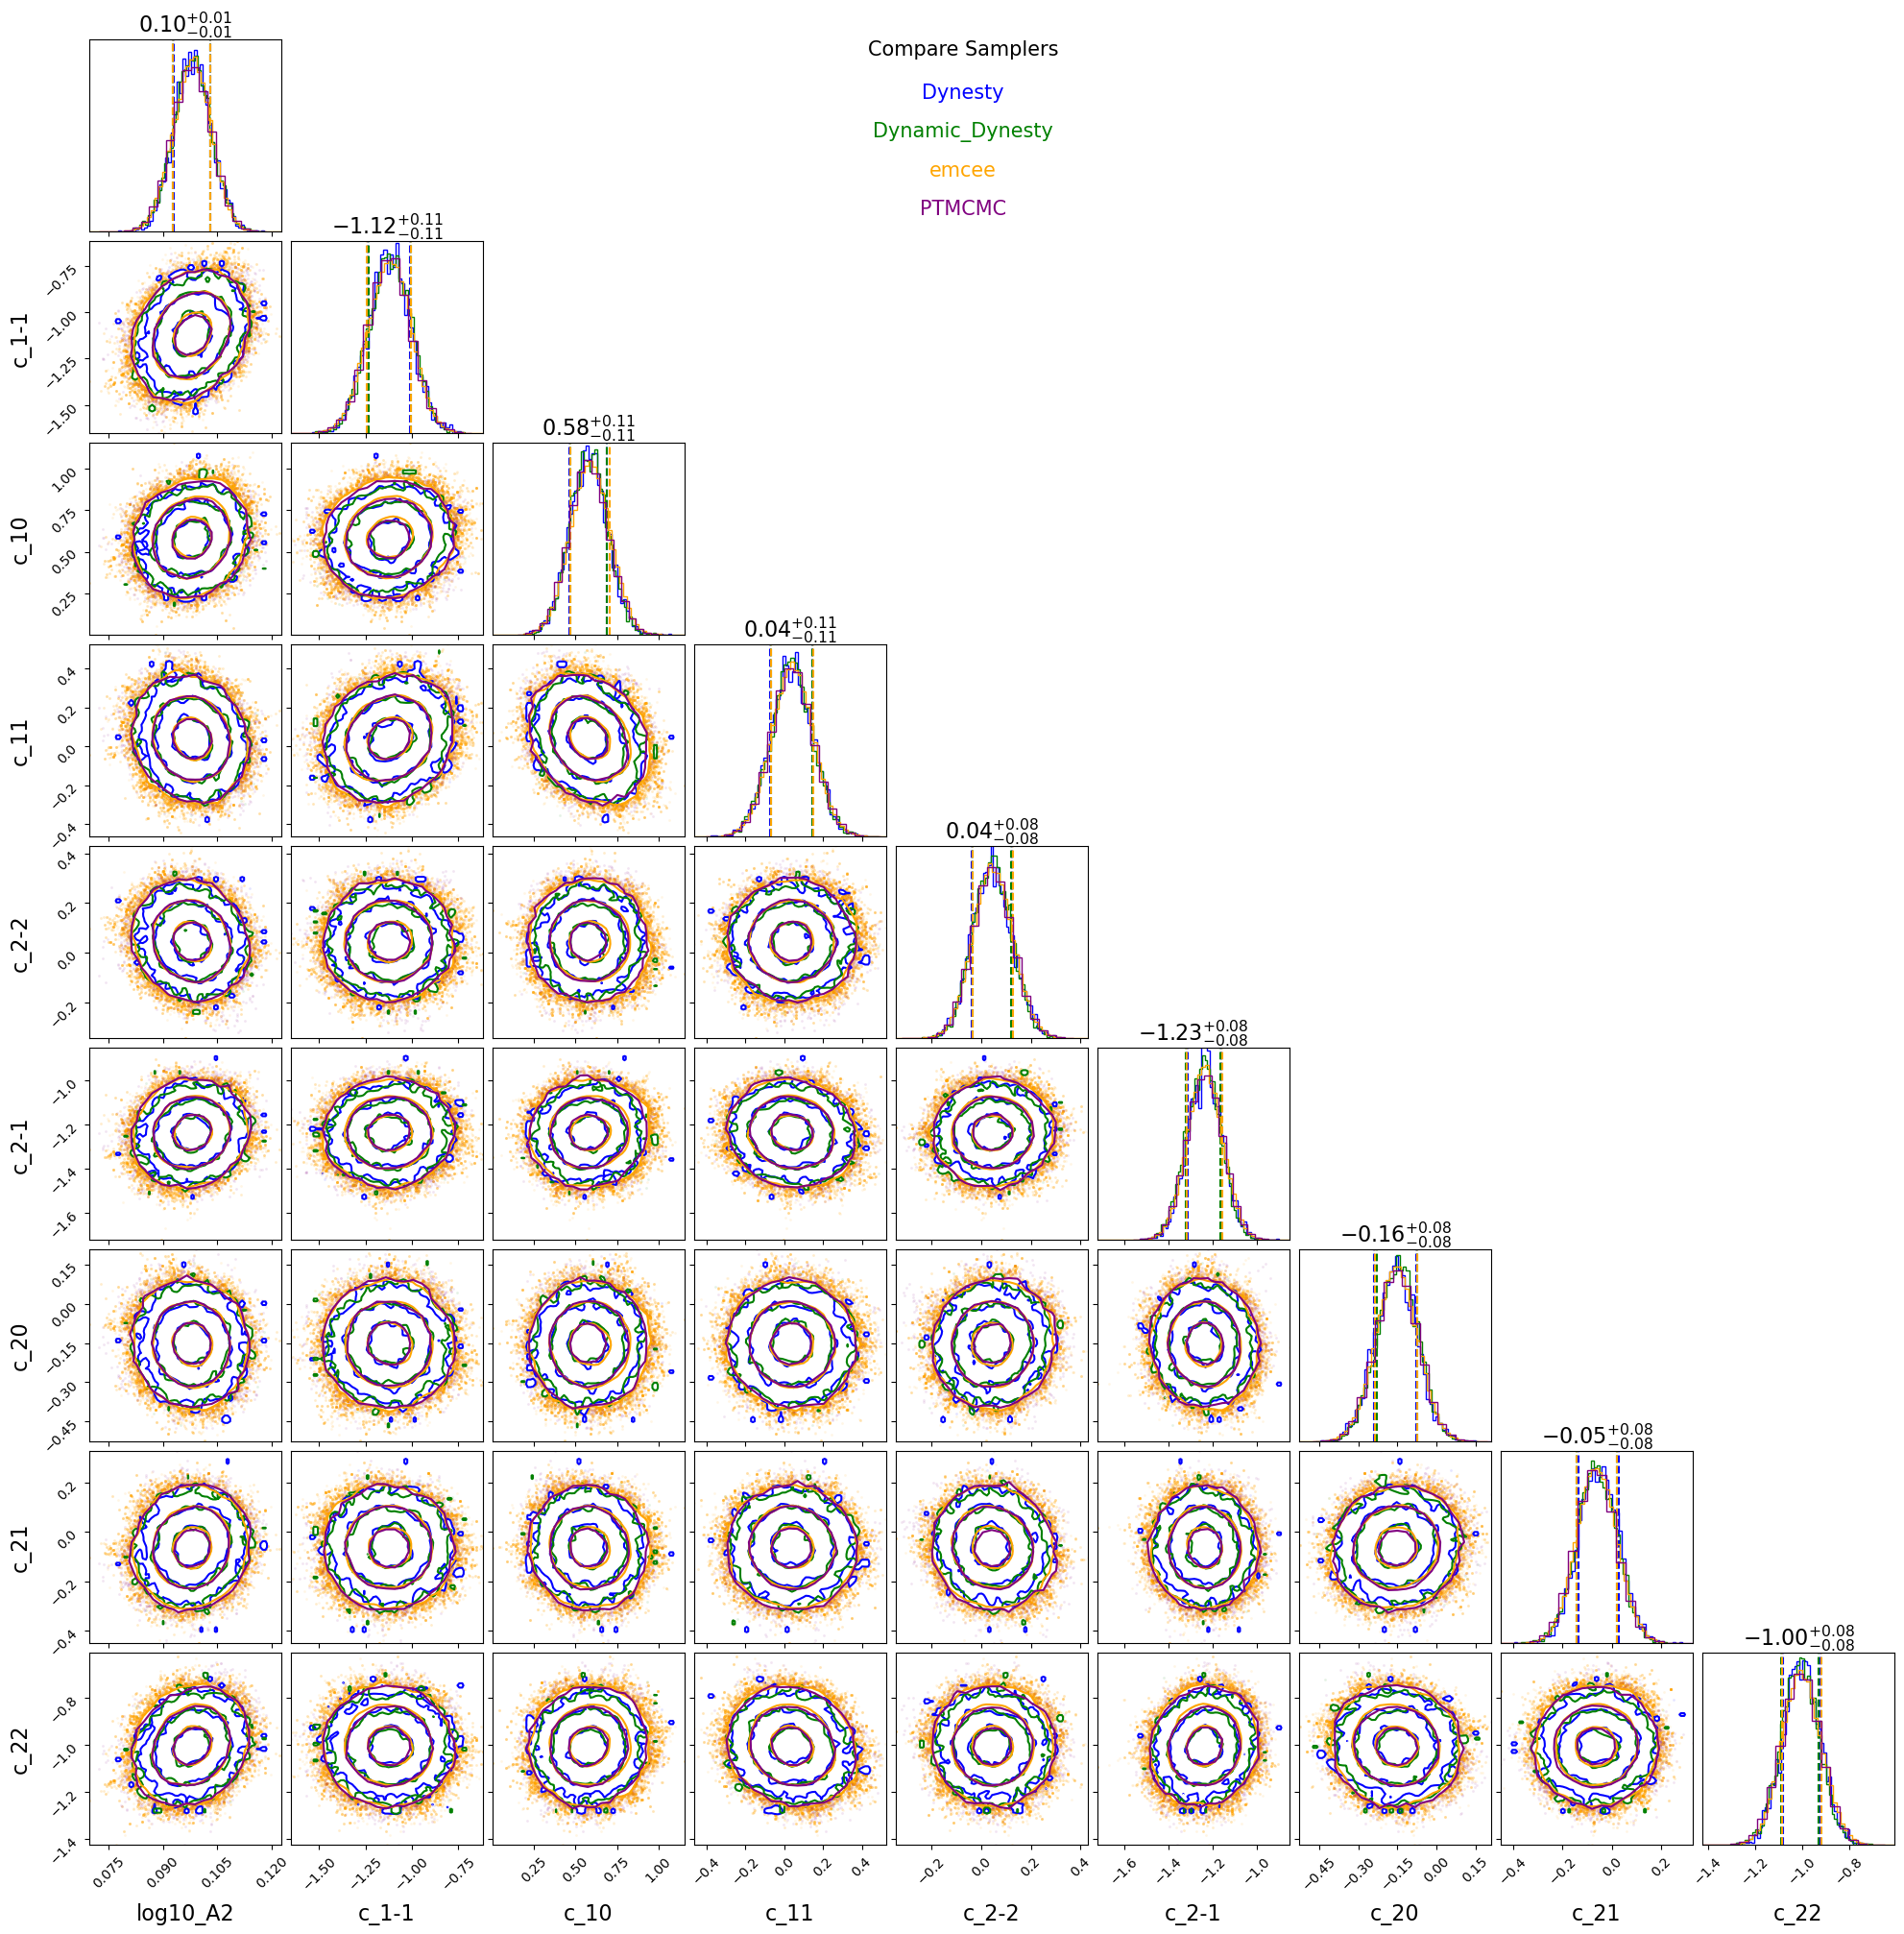

In [38]:
fig = results['dynesty'].plot_corner(parameters=results['dynesty'].parameter_labels[:9], 
                                     plot_datapoints=True, fill_contours=False, plot_density=False,
                                     save=False, color='blue', title_quantiles=[0.16, 0.5, 0.84], 
                                     hist_kwargs=dict(density=True, histtype="step"))

results['dynamic_dynesty'].plot_corner(parameters=results['dynamic_dynesty'].parameter_labels[:9], fig=fig, 
                                       plot_datapoints=True, fill_contours=False, plot_density=False,
                                       save=False, color='green', title_quantiles=[0.16, 0.5, 0.84], 
                                       hist_kwargs=dict(density=True, histtype="step"))

results['emcee'].plot_corner(parameters=results['emcee'].parameter_labels[:9], fig=fig, 
                             plot_datapoints=True, fill_contours=False, plot_density=False,
                             save=False, color='orange', title_quantiles=[0.16, 0.5, 0.84], 
                             hist_kwargs=dict(density=True, histtype="step"))

corner.corner(ptmcmc_corner_params[:, :9], fig=fig, 
              plot_datapoints=True, fill_contours=False, plot_density=False, 
              color='purple', levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), 
              labels=pta.param_names[:9], title_quantiles=[0.16, 0.5, 0.84], 
              hist_kwargs=dict(density=True, histtype="step"))


fig.suptitle('Compare Samplers', fontsize=15)
fig.text(0.5, 0.95, "Dynesty", color='blue', ha="center", fontsize=15)
fig.text(0.5, 0.93, "Dynamic_Dynesty", color='green', ha="center", fontsize=15)
fig.text(0.5, 0.91, "emcee", color='orange', ha="center", fontsize=15)
fig.text(0.5, 0.89, "PTMCMC", color='purple', ha="center", fontsize=15)


plt.show()

##### Here, we see contours overlap very well for all the samplers.

#### 4. Recovered power-map, $C_{l}$ and ORF 

First, we need to obtain their samples using the $c_{lm}$ posterior samples. We use a handy funtion in utils to do so. ``` utils.posterior_sampled_skymap_Cl_orf(pta, data, n_draws) ``` return collection of power-maps, Cl, ORF randomly drawn from the given posteriors in data of shape ($N_{pars} \times N_{samples}$) where the number of draws are fixed by $n_{draws}$.

In [69]:
#results['dynamic_dynesty'].posterior.to_numpy().T.shape

(27, 6248)

In [70]:
rec_pow_map_dynesty, rec_Cl_dynesty, rec_orf_dynesty = \
utils.posterior_sampled_skymap_Cl_orf(pta, data=results['dynesty'].posterior.to_numpy().T, n_draws=4000)

rec_pow_map_ddynesty, rec_Cl_ddynesty, rec_orf_ddynesty = \
utils.posterior_sampled_skymap_Cl_orf(pta, data=results['dynamic_dynesty'].posterior.to_numpy().T, n_draws=5000)

rec_pow_map_emcee, rec_Cl_emcee, rec_orf_emcee = \
utils.posterior_sampled_skymap_Cl_orf(pta, data=results['emcee'].posterior.to_numpy().T, n_draws=5000)

rec_pow_map_ptmcmc, rec_Cl_ptmcmc, rec_orf_ptmcmc = \
utils.posterior_sampled_skymap_Cl_orf(pta, data=ptmcmc_corner_params.T, n_draws=5000)

n_draw: 100%|██████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.95it/s]


Now get the median of each and plot them

In [71]:
### Get the median of power-map, Cl and orf distribution

rec_pow_map_dynesty_med = [np.median(rec_pow_map_dynesty[:, i]) for i in range(pta.npix)]
rec_Cl_dynesty_med = [np.median(rec_Cl_dynesty[:, i]) for i in range(pta.l_max+1)]
rec_orf_dynesty_med = [np.median(rec_orf_dynesty[:, i]) for i in range(pta.npairs)]

rec_pow_map_ddynesty_med = [np.median(rec_pow_map_ddynesty[:, i]) for i in range(pta.npix)]
rec_Cl_ddynesty_med = [np.median(rec_Cl_ddynesty[:, i]) for i in range(pta.l_max+1)]
rec_orf_ddynesty_med = [np.median(rec_orf_ddynesty[:, i]) for i in range(pta.npairs)]

rec_pow_map_emcee_med = [np.median(rec_pow_map_emcee[:, i]) for i in range(pta.npix)]
rec_Cl_emcee_med = [np.median(rec_Cl_emcee[:, i]) for i in range(pta.l_max+1)]
rec_orf_emcee_med = [np.median(rec_orf_emcee[:, i]) for i in range(pta.npairs)]

rec_pow_map_ptmcmc_med = [np.median(rec_pow_map_ptmcmc[:, i]) for i in range(pta.npix)]
rec_Cl_ptmcmc_med = [np.median(rec_Cl_ptmcmc[:, i]) for i in range(pta.l_max+1)]
rec_orf_ptmcmc_med = [np.median(rec_orf_ptmcmc[:, i]) for i in range(pta.npairs)]

#### Recovered orf

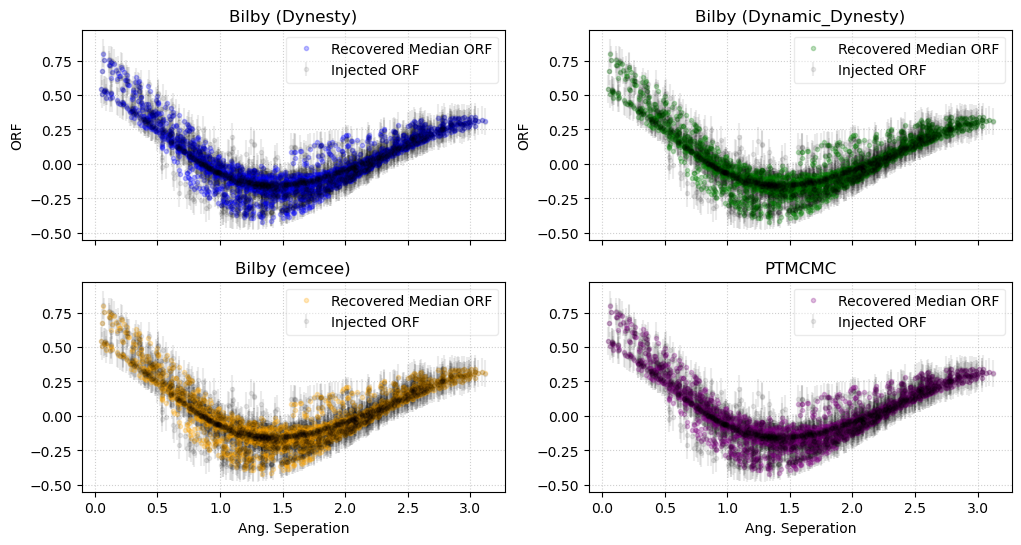

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)


### Bilby ORF recovery
ax[0][0].errorbar(pta.xi, pta.injected_rho, pta.injected_sig, ls='', color='black', marker='.', alpha=0.08, label='Injected ORF')
ax[0][0].plot(pta.xi, rec_orf_dynesty_med, color='blue', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[0][0].set_ylabel(r"ORF")
ax[0][0].legend(framealpha=0.4)
ax[0][0].grid(ls=':', alpha=0.6)
ax[0][0].set_title('Bilby (Dynesty)')

ax[0][1].errorbar(pta.xi, pta.injected_rho, pta.injected_sig, ls='', color='black', marker='.', alpha=0.08, label='Injected ORF')
ax[0][1].plot(pta.xi, rec_orf_ddynesty_med, color='green', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[0][1].set_ylabel(r"ORF")
ax[0][1].legend(framealpha=0.4)
ax[0][1].grid(ls=':', alpha=0.6)
ax[0][1].set_title('Bilby (Dynamic_Dynesty)')

ax[1][0].errorbar(pta.xi, pta.injected_rho, pta.injected_sig, ls='', color='black', marker='.', alpha=0.08, label='Injected ORF')
ax[1][0].plot(pta.xi, rec_orf_emcee_med, color='orange', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[1][0].set_xlabel(r"Ang. Seperation")
ax[1][0].legend(framealpha=0.4)
ax[1][0].grid(ls=':', alpha=0.6)
ax[1][0].set_title('Bilby (emcee)')

ax[1][1].errorbar(pta.xi, pta.injected_rho, pta.injected_sig, ls='', color='black', marker='.', alpha=0.08, label='Injected ORF')
ax[1][1].plot(pta.xi, rec_orf_ptmcmc_med, color='purple', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[1][1].set_xlabel(r"Ang. Seperation")
ax[1][1].legend(framealpha=0.4)
ax[1][1].grid(ls=':', alpha=0.6)
ax[1][1].set_title('PTMCMC')



plt.show()

#### Recovered $C_{l}$

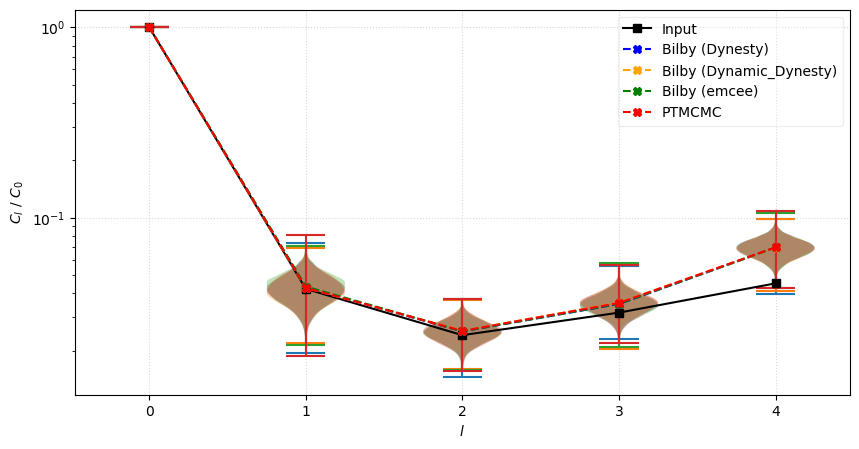

In [75]:
plt.figure(figsize=(10, 5))

plt.violinplot(rec_Cl_dynesty/rec_Cl_dynesty[0][0], positions=range(pta.l_max+1), showextrema=True)
plt.violinplot(rec_Cl_ddynesty/rec_Cl_ddynesty[0][0], positions=range(pta.l_max+1), showextrema=True)
plt.violinplot(rec_Cl_emcee/rec_Cl_emcee[0][0], positions=range(pta.l_max+1), showextrema=True)
plt.violinplot(rec_Cl_ptmcmc/rec_Cl_ptmcmc[0][0], positions=range(pta.l_max+1), showextrema=True)

plt.plot(range(pta.l_max+1), pta.injected_Cl/pta.injected_Cl[0], color='black', marker='s', label='Input')
plt.plot(range(pta.l_max+1), rec_Cl_dynesty_med/rec_Cl_dynesty_med[0], color='blue', ls ='--', marker='X', label='Bilby (Dynesty)')
plt.plot(range(pta.l_max+1), rec_Cl_ddynesty_med/rec_Cl_ddynesty_med[0], color='orange', ls ='--', marker='X', label='Bilby (Dynamic_Dynesty)')
plt.plot(range(pta.l_max+1), rec_Cl_emcee_med/rec_Cl_emcee_med[0], color='green', ls ='--', marker='X', label='Bilby (emcee)')
plt.plot(range(pta.l_max+1), rec_Cl_ptmcmc_med/rec_Cl_ptmcmc_med[0], color='red', ls ='--', marker='X', label='PTMCMC')

plt.xlabel(r'$l$')
plt.ylabel(r'$C_{l} \ / \ C_{0}$')

plt.yscale('log')

plt.legend(framealpha=0.3)
plt.grid(ls=':', alpha=0.5)
plt.show()

#### Recovered power-map

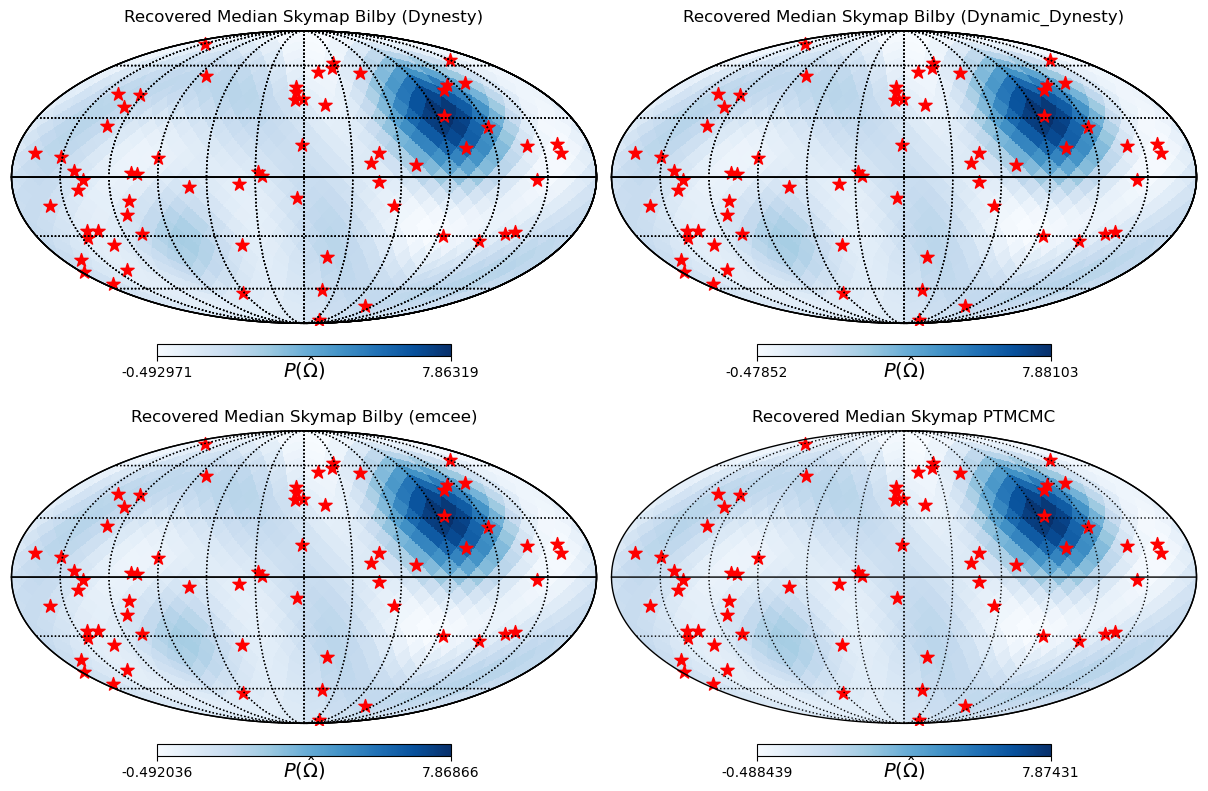

In [74]:
plt.figure(figsize=(12, 8))

hp.mollview(np.array(rec_pow_map_dynesty_med), sub=221, title = 'Recovered Median Skymap Bilby (Dynesty)',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_ddynesty_med), sub=222, title = 'Recovered Median Skymap Bilby (Dynamic_Dynesty)',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_emcee_med), sub=223, title = 'Recovered Median Skymap Bilby (emcee)',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_ptmcmc_med), sub=224, title = 'Recovered Median Skymap PTMCMC',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.projscatter(pta.psrs_theta, pta.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()